# **Projet : Computer vision**

---***Classification d’Images Médicales pour la Détection de Cancer***---

Ce projet à pour objectif de développer un modèle de deep learning basé sur une architecture CNN pour classifier des images médicales et détecter des tumeurs, comme le mélanome dans des images de peau. Le projet doit inclure au moins trois classes différentes (par exemple : bénin, malin, et une autre catégorie comme les lésions précancéreuses). Voici les grandes lignes :

- **Tâche** : Classification d’images médicales (détection de cancer).
- **Dataset utilisé** : ISIC Challenge - Lesions Classification (disponible sur leur site officiel).
- **Architecture** : Une CNN existante comme ResNet, avec possibilité d’utiliser le *transfer learning*.


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

### ***Dataset***

Le dataset provient du challenge ISIC et contient des images de lésions cutanées annotées selon trois classes: bénin, malin et indéterminé. Il est divisé en trois ensembles :
- **Entraînement** : Pour apprendre les poids du modèle.
- **Validation** : Pour ajuster les hyperparamètres et éviter le surapprentissage.
- **Test** : Pour évaluer les performances finales.


In [2]:
# Chemins vers les données
image_dir_train = 'G:/Mon Drive/MALIA/Recent advanced in IA/Projet/ISIC_images_training_2017'
image_dir_test = 'G:/Mon Drive/MALIA/Recent advanced in IA/Projet/ISIC_images_test_2017'
image_dir_val = 'G:/Mon Drive/MALIA/Recent advanced in IA/Projet/ISIC_images_validation_2017'

# Fichiers CSV avec annotations
labels_file_train = 'G:/Mon Drive/MALIA/Recent advanced in IA/Projet/ISIC_images_training_2017/metadata.csv'
labels_file_test = 'G:/Mon Drive/MALIA/Recent advanced in IA/Projet/ISIC_images_test_2017/metadata.csv'
labels_file_val = 'G:/Mon Drive/MALIA/Recent advanced in IA/Projet/ISIC_images_validation_2017/metadata.csv'


### **Chargement des annotations**
Une fonction `load_annotations` est utilisée pour charger les fichiers CSV contenant les métadonnées et associer chaque image à son chemin complet et son label :

In [3]:
# Charger les annotations et créer le chemin complet des images
def load_annotations(csv_file, image_dir, label_col):
    df = pd.read_csv(csv_file)
    df['image_path'] = df['isic_id'].apply(lambda x: os.path.join(image_dir, x + '.jpg'))
    # Pour garantir la cohérence, on renomme la colonne des labels en 'label'
    df = df.rename(columns={label_col: 'label'})
    return df

# Charger les annotations
train_df = load_annotations(labels_file_train, image_dir_train, label_col='diagnosis_1')
val_df   = load_annotations(labels_file_val, image_dir_val, label_col='benign_malignant')
test_df  = load_annotations(labels_file_test, image_dir_test, label_col='benign_malignant')

## **Préparation des Données et Générateurs**

Les images sont prétraitées pour être compatibles avec ResNet-50 et pour améliorer les performances du modèle.

### **Prétraitement**
- **Normalisation** : Les valeurs des pixels sont divisées par 255 pour les ramener entre 0 et 1, ce qui est requis par ResNet-50.
- **Augmentation des données** : Pour l’entraînement, des transformations aléatoires (rotation, décalages, zoom, etc.) sont appliquées pour augmenter la diversité des données et réduire le risque de surapprentissage.

### **Générateurs d’images**
Trois générateurs sont créés avec `ImageDataGenerator` :

*  **`train_datagen`** : Inclut l’augmentation des données pour l’entraînement.
*  **`val_datagen` et `test_datagen`** : Seulement normalisation, sans augmentation, pour une évaluation cohérente.
* **`flow_from_dataframe`** : Charge les images à partir des dataframes en batches(***taille=32***), avec une taille cible de 224x224 pixels (standard pour ResNet-50).


In [4]:
# Définir les générateurs d’images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Créer les générateurs à partir des dataframes
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2000 validated image filenames belonging to 3 classes.
Found 150 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


## **Visualisation des Données**
Pour vérifier la cohérence des données, nous affichons quelques images avec leurs labels et analysons la distribution des classes :


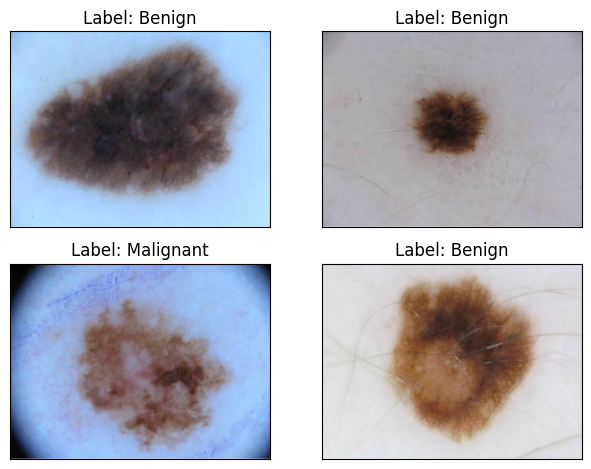

Train: label
Benign           1625
Malignant         374
Indeterminate       1
Name: count, dtype: int64
Validation: label
benign           119
malignant         30
indeterminate      1
Name: count, dtype: int64
Test: label
benign           481
malignant        117
indeterminate      2
Name: count, dtype: int64


In [5]:
import matplotlib.pyplot as plt

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img_path = train_df['image_path'].iloc[i]
    label = train_df['label'].iloc[i]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"Label: {label}")
plt.tight_layout()
plt.show()

print("Train:", train_df['label'].value_counts())
print("Validation:", val_df['label'].value_counts())
print("Test:", test_df['label'].value_counts())

## **Choix et Configuration de l’Architecture**

Nous utilisons **ResNet-50**, une CNN pré-entraînée sur ImageNet, en raison de ses connexions résiduelles qui facilitent l’apprentissage de caractéristiques complexes.
Le transfer learning est utilisé en gelant les couches de base et en ajoutant des couches personnalisées pour la classification en trois classes.

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Charger ResNet50 pré-entraîné sur ImageNet sans la couche top
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Pour régulariser
predictions = Dense(3, activation='softmax')(x)  # 3 classes : pour bénin, malin, et lésions précancéreuses

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# degeler les couches du modèle de base pour l'entraînement
for layer in base_model.layers:
    layer.trainable = True

## **Entraînement du Modèle**

Le modèle est entraîné avec les hyperparamètres suivants :

* **Optimiseur** : Adam
* **Fonction de perte** : Categorical Crossentropy
* **Métriques** : Précision, précision par classe, rappel
* **Batch size** : 32
* **Époques** : 50 (avec early stopping, patience = 10)
* **`callbacks`** :
  - `EarlyStopping` : Arrête l’entraînement si la perte de validation ne s’améliore pas après 10 époques.
  - `ModelCheckpoint` : Sauvegarde le meilleur modèle basé sur la perte de validation.
  - `ReduceLROnPlateau` : Réduit le taux d’apprentissage si la perte stagne.


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

# Calculer les poids de classe pour l'entraînement
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Compiler le modèle
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy', 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

# Callbacks pour l’entraînement
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("C:/Projet_NRA/best_model.h5", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
]

# Entraîner le modèle
history = model.fit(
    train_generator,
    class_weight=class_weights,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks
)

c:\Users\somem\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4820 - loss: 14.7187 - precision_1: 0.4990 - recall_1: 0.4106

63/63 ━━━━━━━━━━━━━━━━━━━━ 530s 8s/step - accuracy: 0.4828 - loss: 14.7241 - precision_1: 0.4998 - recall_1: 0.4118 - val_accuracy: 0.7933 - val_loss: 14.1896 - val_precision_1: 0.7933 - val_recall_1: 0.7933 - learning_rate: 1.0000e-05
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5817 - loss: 14.9856 - precision_1: 0.5844 - recall_1: 0.5542

63/63 ━━━━━━━━━━━━━━━━━━━━ 515s 8s/step - accuracy: 0.5816 - loss: 14.9980 - precision_1: 0.5843 - recall_1: 0.5542 - val_accuracy: 0.7933 - val_loss: 14.0024 - val_precision_1: 0.7933 - val_recall_1: 0.7933 - learning_rate: 1.0000e-05
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 565s 9s/step - accuracy: 0.6289 - loss: 14.8031 - precision_1: 0.6330 - recall_1: 0.6037 - val_accuracy: 0.7933 - val_loss: 14.3222 - val_precision_1: 0.7933 - val_recall_1: 0.7933 - learning_rate: 1.0000e-05
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 740s 12s/step - accuracy: 0.6244 - loss: 14.0168 - precision_1: 0.6268 - recall_1: 0.6039 - val_accuracy: 0.7933 - val_loss: 14.6077 - val_precision_1: 0.7933 - val_recall_1: 0.7933 - learning_rate: 1.0000e-05
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 597s 9s/step - accuracy: 0.6468 - loss: 13.9481 - precision_1: 0.6548 - recall_1: 0.6232 - val_accuracy: 0.7933 - val_loss: 14.5819 - val_precision_1: 0.7933 - val_recall_1: 0.7933 - learning_rate: 1.0000e-05
Epoch 6/25
63/63 ━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 554s 9s/step - accuracy: 0.6615 - loss: 13.1998 - precision_1: 0.6682 - recall_1: 0.6430 - val_accuracy: 0.7867 - val_loss: 13.6518 - val_precision_1: 0.7867 - val_recall_1: 0.7867 - learning_rate: 1.0000e-05
Epoch 9/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6824 - loss: 13.0415 - precision_1: 0.6975 - recall_1: 0.6680

63/63 ━━━━━━━━━━━━━━━━━━━━ 496s 8s/step - accuracy: 0.6824 - loss: 13.0448 - precision_1: 0.6974 - recall_1: 0.6680 - val_accuracy: 0.7800 - val_loss: 13.2322 - val_precision_1: 0.7800 - val_recall_1: 0.7800 - learning_rate: 1.0000e-05
Epoch 10/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6829 - loss: 13.0725 - precision_1: 0.6885 - recall_1: 0.6639

63/63 ━━━━━━━━━━━━━━━━━━━━ 506s 8s/step - accuracy: 0.6827 - loss: 13.0751 - precision_1: 0.6884 - recall_1: 0.6636 - val_accuracy: 0.7933 - val_loss: 13.0263 - val_precision_1: 0.7919 - val_recall_1: 0.7867 - learning_rate: 1.0000e-05
Epoch 11/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6682 - loss: 12.8869 - precision_1: 0.6788 - recall_1: 0.6440

63/63 ━━━━━━━━━━━━━━━━━━━━ 511s 8s/step - accuracy: 0.6684 - loss: 12.8859 - precision_1: 0.6790 - recall_1: 0.6441 - val_accuracy: 0.7667 - val_loss: 12.8883 - val_precision_1: 0.7718 - val_recall_1: 0.7667 - learning_rate: 1.0000e-05
Epoch 12/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6911 - loss: 12.7138 - precision_1: 0.7048 - recall_1: 0.6734

63/63 ━━━━━━━━━━━━━━━━━━━━ 550s 9s/step - accuracy: 0.6912 - loss: 12.7141 - precision_1: 0.7048 - recall_1: 0.6734 - val_accuracy: 0.7067 - val_loss: 12.8340 - val_precision_1: 0.7162 - val_recall_1: 0.7067 - learning_rate: 1.0000e-05
Epoch 13/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6923 - loss: 12.6299 - precision_1: 0.7014 - recall_1: 0.6751

63/63 ━━━━━━━━━━━━━━━━━━━━ 543s 9s/step - accuracy: 0.6926 - loss: 12.6295 - precision_1: 0.7016 - recall_1: 0.6753 - val_accuracy: 0.7200 - val_loss: 12.7370 - val_precision_1: 0.7329 - val_recall_1: 0.7133 - learning_rate: 1.0000e-05
Epoch 14/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6953 - loss: 12.5085 - precision_1: 0.7015 - recall_1: 0.6873

63/63 ━━━━━━━━━━━━━━━━━━━━ 508s 8s/step - accuracy: 0.6952 - loss: 12.5085 - precision_1: 0.7013 - recall_1: 0.6871 - val_accuracy: 0.7333 - val_loss: 12.6170 - val_precision_1: 0.7432 - val_recall_1: 0.7333 - learning_rate: 1.0000e-05
Epoch 15/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6986 - loss: 12.4241 - precision_1: 0.7053 - recall_1: 0.6858

63/63 ━━━━━━━━━━━━━━━━━━━━ 519s 8s/step - accuracy: 0.6984 - loss: 12.4240 - precision_1: 0.7051 - recall_1: 0.6856 - val_accuracy: 0.8067 - val_loss: 12.4752 - val_precision_1: 0.8054 - val_recall_1: 0.8000 - learning_rate: 1.0000e-05
Epoch 16/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7040 - loss: 12.3554 - precision_1: 0.7075 - recall_1: 0.6940

63/63 ━━━━━━━━━━━━━━━━━━━━ 498s 8s/step - accuracy: 0.7039 - loss: 12.3552 - precision_1: 0.7073 - recall_1: 0.6939 - val_accuracy: 0.8200 - val_loss: 12.3682 - val_precision_1: 0.8200 - val_recall_1: 0.8200 - learning_rate: 1.0000e-05
Epoch 17/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7173 - loss: 12.2450 - precision_1: 0.7228 - recall_1: 0.7050

63/63 ━━━━━━━━━━━━━━━━━━━━ 522s 8s/step - accuracy: 0.7172 - loss: 12.2448 - precision_1: 0.7227 - recall_1: 0.7049 - val_accuracy: 0.8200 - val_loss: 12.2525 - val_precision_1: 0.8188 - val_recall_1: 0.8133 - learning_rate: 1.0000e-05
Epoch 18/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6927 - loss: 12.1651 - precision_1: 0.7000 - recall_1: 0.6830

63/63 ━━━━━━━━━━━━━━━━━━━━ 516s 8s/step - accuracy: 0.6930 - loss: 12.1643 - precision_1: 0.7004 - recall_1: 0.6834 - val_accuracy: 0.8333 - val_loss: 12.1556 - val_precision_1: 0.8333 - val_recall_1: 0.8333 - learning_rate: 1.0000e-05
Epoch 19/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7164 - loss: 12.0557 - precision_1: 0.7238 - recall_1: 0.7098

63/63 ━━━━━━━━━━━━━━━━━━━━ 513s 8s/step - accuracy: 0.7162 - loss: 12.0557 - precision_1: 0.7236 - recall_1: 0.7096 - val_accuracy: 0.8267 - val_loss: 12.0666 - val_precision_1: 0.8267 - val_recall_1: 0.8267 - learning_rate: 1.0000e-05
Epoch 20/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7210 - loss: 11.9754 - precision_1: 0.7242 - recall_1: 0.7100

63/63 ━━━━━━━━━━━━━━━━━━━━ 523s 8s/step - accuracy: 0.7210 - loss: 11.9752 - precision_1: 0.7242 - recall_1: 0.7101 - val_accuracy: 0.8200 - val_loss: 11.9785 - val_precision_1: 0.8200 - val_recall_1: 0.8200 - learning_rate: 1.0000e-05
Epoch 21/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7018 - loss: 11.8773 - precision_1: 0.7048 - recall_1: 0.6909

63/63 ━━━━━━━━━━━━━━━━━━━━ 518s 8s/step - accuracy: 0.7019 - loss: 11.8771 - precision_1: 0.7050 - recall_1: 0.6911 - val_accuracy: 0.8267 - val_loss: 11.9041 - val_precision_1: 0.8255 - val_recall_1: 0.8200 - learning_rate: 1.0000e-05
Epoch 22/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7246 - loss: 11.7757 - precision_1: 0.7313 - recall_1: 0.7159

63/63 ━━━━━━━━━━━━━━━━━━━━ 499s 8s/step - accuracy: 0.7246 - loss: 11.7753 - precision_1: 0.7314 - recall_1: 0.7160 - val_accuracy: 0.8400 - val_loss: 11.8096 - val_precision_1: 0.8400 - val_recall_1: 0.8400 - learning_rate: 1.0000e-05
Epoch 23/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7150 - loss: 11.6816 - precision_1: 0.7186 - recall_1: 0.7084

63/63 ━━━━━━━━━━━━━━━━━━━━ 459s 7s/step - accuracy: 0.7151 - loss: 11.6814 - precision_1: 0.7187 - recall_1: 0.7085 - val_accuracy: 0.8400 - val_loss: 11.7195 - val_precision_1: 0.8400 - val_recall_1: 0.8400 - learning_rate: 1.0000e-05
Epoch 24/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7221 - loss: 11.5990 - precision_1: 0.7247 - recall_1: 0.7118

63/63 ━━━━━━━━━━━━━━━━━━━━ 460s 7s/step - accuracy: 0.7223 - loss: 11.5987 - precision_1: 0.7249 - recall_1: 0.7120 - val_accuracy: 0.8067 - val_loss: 11.6409 - val_precision_1: 0.8121 - val_recall_1: 0.8067 - learning_rate: 1.0000e-05
Epoch 25/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7467 - loss: 11.4673 - precision_1: 0.7479 - recall_1: 0.7379

63/63 ━━━━━━━━━━━━━━━━━━━━ 458s 7s/step - accuracy: 0.7468 - loss: 11.4671 - precision_1: 0.7481 - recall_1: 0.7380 - val_accuracy: 0.8400 - val_loss: 11.5518 - val_precision_1: 0.8400 - val_recall_1: 0.8400 - learning_rate: 1.0000e-05


## **Évaluation du Modèle**

L’évaluation inclut des résultats quantitatifs (précision, rappel, AUC-ROC) et qualitatifs (visualisations Grad-CAM).

### ***Résultats quantitatifs***

* **Matrice de confusion** : Montre les prédictions correctes et incorrectes par classe.
* **Rapport de classification** : Fournit précision, rappel et F1-score pour chaque classe.
* **AUC-ROC** : Mesure la capacité du modèle à distinguer les classes (approche "one-vs-rest" pour multi-classes).

19/19 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step


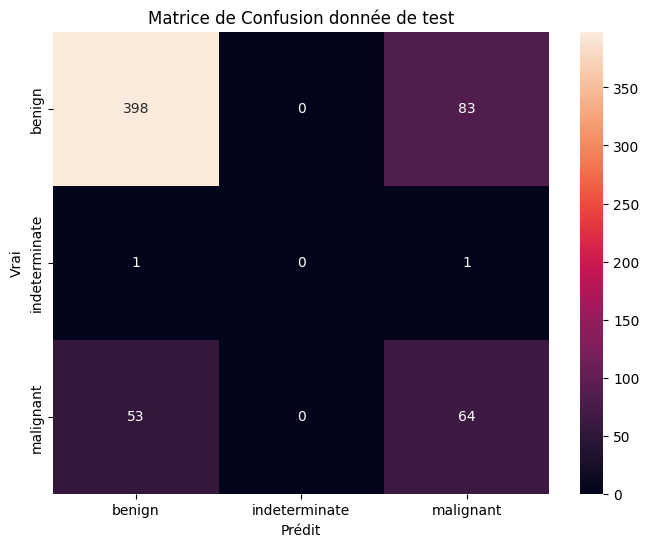

c:\Users\somem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\somem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\somem\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

               precision    recall  f1-score   support

       benign       0.88      0.83      0.85       481
indeterminate       0.00      0.00      0.00         2
    malignant       0.43      0.55      0.48       117

     accuracy                           0.77       600
    macro avg       0.44      0.46      0.45       600
 weighted avg       0.79      0.77      0.78       600

19/19 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step
AUC-ROC: 0.6275


In [11]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns

true_classes = test_generator.classes
class_names = list(test_generator.class_indices.keys())
predicted_classes = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.title('Matrice de Confusion donnée de test')
plt.show()

print(classification_report(true_classes, predicted_classes, target_names=class_names))
auc = roc_auc_score(true_classes, model.predict(test_generator), multi_class='ovr')
print(f'AUC-ROC: {auc:.4f}')

### ***Visualisation Grad-CAM***

***Résultats qualitatifs***

**Grad-CAM** : Visualise les régions de l’image influençant la prédiction, utile pour interpréter les décisions du modèle dans un contexte médical.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


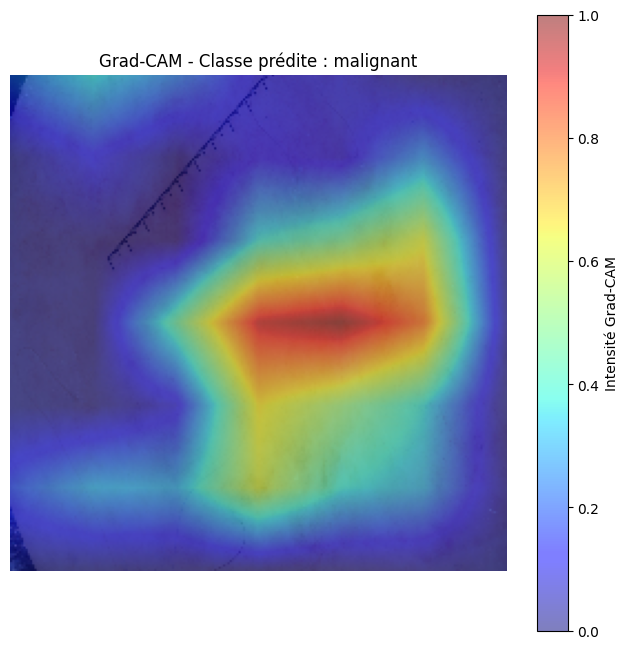

In [9]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore

# Créer une instance de Gradcam
gradcam = Gradcam(model)

# Préparer une image test (assurez-vous qu'elle est normalisée entre 0 et 1)
img = test_generator[0][0][17]  # Première image du batch test
img_batch = np.expand_dims(img, axis=0)

# Générer Grad-CAM pour la classe prédite
pred = model.predict(img_batch)
class_idx = np.argmax(pred[0])
score = CategoricalScore(class_idx)
cam = gradcam(score, img_batch, penultimate_layer=-1)[0]
cam = (cam - cam.min()) / (cam.max() - cam.min())

# Affichage
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.colorbar(label='Intensité Grad-CAM')
plt.title(f"Grad-CAM - Classe prédite : {class_names[class_idx]}")
plt.axis('off')
plt.show()

### **Visualisation des résultats**

Des courbes de précision et de perte sont générées pour analyser la convergence.

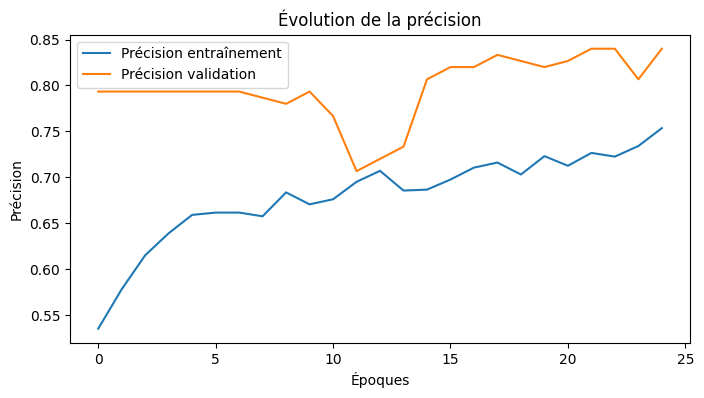

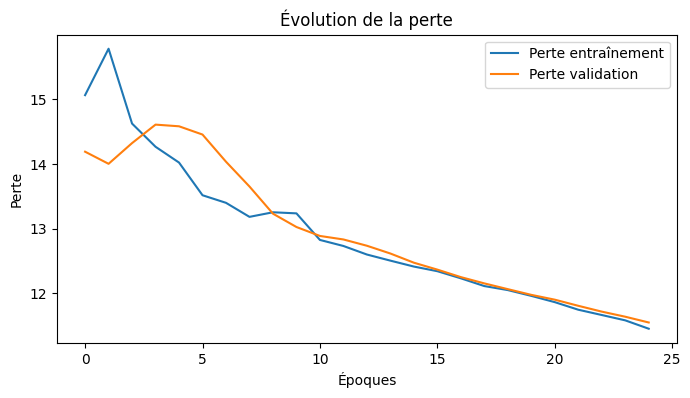

In [10]:
import matplotlib.pyplot as plt

# Courbe de précision
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Précision entraînement')
plt.plot(history.history['val_accuracy'], label='Précision validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.title("Évolution de la précision")
plt.show()

# Courbe de perte
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.title("Évolution de la perte")
plt.show()